# Example modified from [zhulingchen/tfp-tutorial](https://github.com/zhulingchen/tfp-tutorial/blob/master/tfp_bnn.ipynb)

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Loading MNIST dataset
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


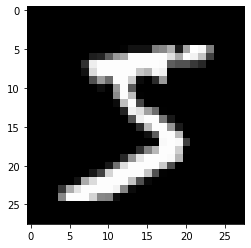

In [2]:
print('Loading MNIST dataset')
num_classes = 10
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[0, :, :, 0], cmap='gist_gray')
plt.show()

In [3]:
def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [4]:
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

In [7]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

In [ ]:
def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    conv_2 = tfp.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    dense_1 = tfp.layers.DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = tfp.layers.DenseFlipout(10, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], n_train)
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=tf.keras.optimizers.Adam(), metrics=['acc'],
                   experimental_run_tf_function=False)
bcnn_model.summary()
hist = bcnn_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.1)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout_8 (Conv2DFlip (None, 14, 14, 32)        609       
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_9 (Conv2DFlip (None, 7, 7, 64)          36929     
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
activation_9 (Activation)    (None, 7, 7, 64)          0   